In [36]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import dbfe

In [25]:
variant_type = "DEL"
pos_class = "RES"

stat_vals = pd.read_csv(f"../experiments/data/ovarian/ovarian_cnv.csv.gz", index_col='SAMPLEID')
stat_vals = stat_vals.loc[stat_vals.SVCLASS == variant_type, :]
stat_vals = stat_vals.groupby(stat_vals.index)['LEN'].apply(list).to_frame()

labels = pd.read_csv(f"../experiments/data/ovarian/labels.tsv", sep='\t', index_col=0)
labels = (labels == pos_class) * 1
stat_df = stat_vals.join(labels.CLASS_LABEL, how='inner')

stat_df

,LEN,CLASS_LABEL
CPCT02010646T,"[339068, 99019, 124463, 75553, 157365, 88249, ...",0
CPCT02010679T,"[28911668, 90828442, 174326, 162267, 30594, 77...",0
CPCT02020307T,"[1776581, 124818, 716325, 7281449, 2640338, 36...",1
CPCT02020333T,"[767016, 1689640, 28817694, 28186777, 1394127,...",1
CPCT02020420T,"[2366861, 10411937, 59616662, 44211, 13166450,...",0
...,...,...
TCGA-36-1570-01A,"[37248, 198462, 11435934, 21717737, 7998166, 1...",1
TCGA-36-1571-01A,"[44211, 335207, 315813, 2516724, 631985, 15648...",1
TCGA-36-1574-01A,"[26054, 10585377, 47714, 1990, 356342, 4932892...",1
TCGA-61-2000-01A,"[122287, 512304, 78553, 77328, 48860, 115082, ...",0


In [26]:
X = stat_df.loc[:, "LEN"]
y = stat_df.loc[:, "CLASS_LABEL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, stratify=y)

AUC on test data: 0.694


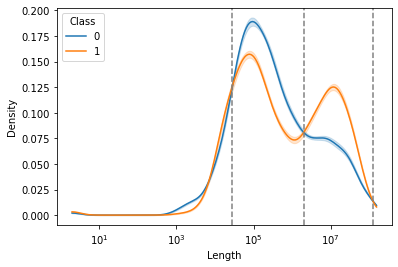

In [42]:
extractor = dbfe.DistributionBasedFeatureExtractor(breakpoint_type='supervised', n_bins='auto', cv=10)
pipe = make_pipeline(extractor, StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)
extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde', plot_ax=ax, subplot=True);
figure = ax.get_figure()
figure.savefig("img/dbfe_plot.svg");

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))